# Importing libraries

In [1]:
import os
import json
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def table(results, labels):
    rows = []
    for i, result in enumerate(results):
        row = {
            'Model': labels[i],
            'Z500 6H': round(result.sel(lead_time=6).z.item(), 3), 
            'Z500 120H':round(result.sel(lead_time=120).z.item(), 3), 
            'T850 6H': round(result.sel(lead_time=6).t.item(), 3),
            'T850 120H':round(result.sel(lead_time=120).t.item(), 3)
        }
        rows.append(row)

    df = pd.DataFrame(rows).set_index('Model')
    
    return df

In [3]:
figures_path = '../data/healpix/s02_results/'
if not os.path.isdir(figures_path):
    os.mkdir(figures_path)

# RMSE Comparisons

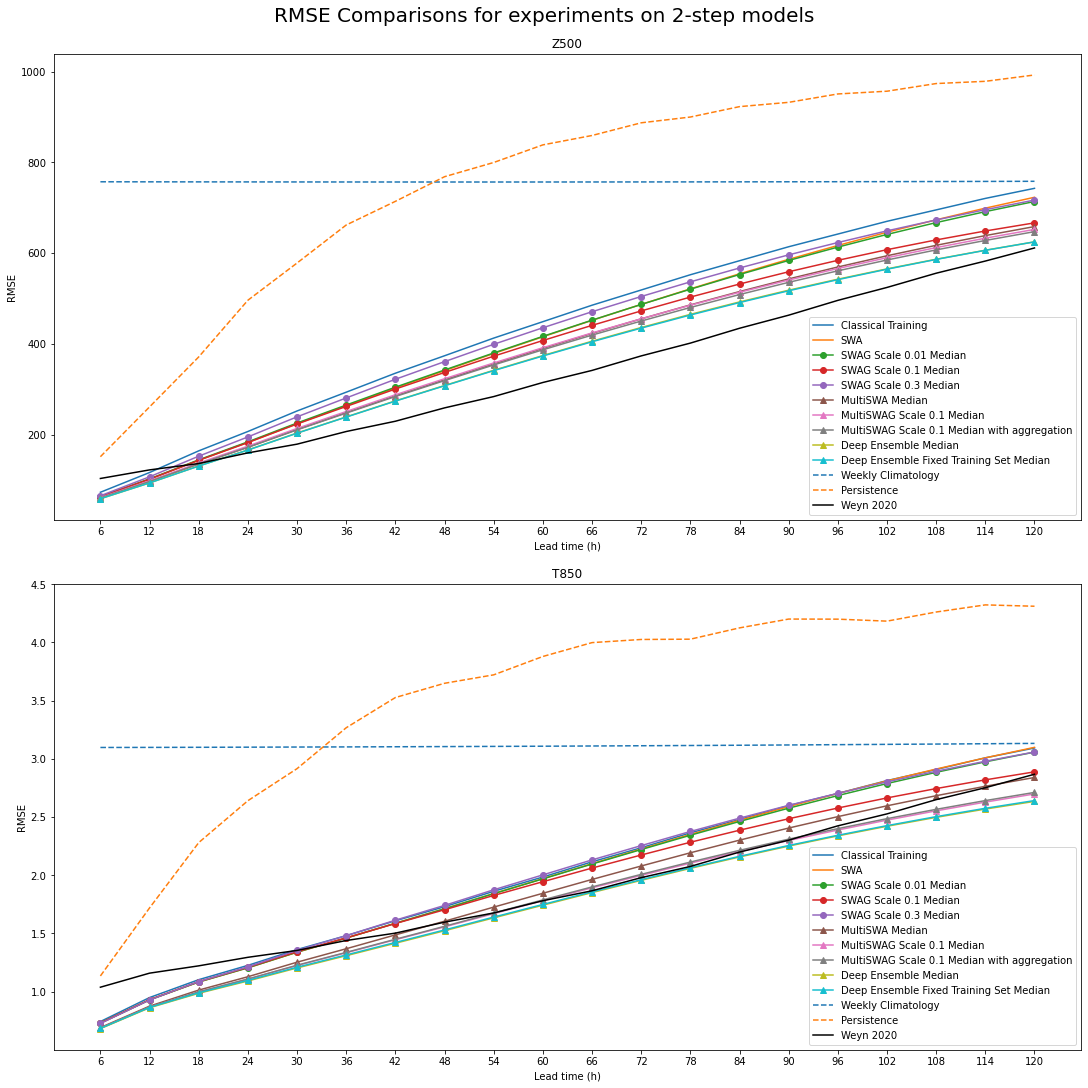

In [4]:
config_file = 'config_s01_two_steps_small.json'
ep = 11
lead_time = 6

# load config
with open("../configs/" + config_file) as json_data_file:
    cfg = json.load(json_data_file)

# define paths
datadir = cfg['directories']['datadir']
input_dir = datadir + cfg['directories']['input_dir']
model_save_path = datadir + cfg['directories']['model_save_path']
pred_save_path = datadir + cfg['directories']['pred_save_path']
metrics_path = datadir + cfg['directories']['metrics_path']

# model parameters
max_lead_time = cfg['training_constants']['max_lead_time']
len_sqce = cfg['model_parameters']['len_sqce']
delta_t = cfg['model_parameters']['delta_t']
architecture_name = cfg['model_parameters']['architecture_name']

lead_times = np.arange(lead_time, max_lead_time + lead_time, lead_time)

description_epoch = "all_const_len{}_delta_{}_architecture_".format(len_sqce, delta_t) + architecture_name
descriptions = [
    description_epoch + f'_s02_epoch_{ep}',
    description_epoch + f'_s02_swag_freq10_epoch_{ep}_swag',
    description_epoch + f'_s02_swag_freq10_epoch_{ep}_swag_scale001_median',
    description_epoch + f'_s02_swag_freq10_epoch_{ep}_swag_scale01_median',
    description_epoch + f'_s02_swag_freq10_epoch_{ep}_swag_scale03_median',
    description_epoch + f'_s02_multiswag_ensemble_epoch_11_swag_scale00_median',
    description_epoch + f'_s02_multiswag_ensemble_epoch_11_swag_scale01_median',
    description_epoch + f'_s02_multiswag_ensemble_epoch_11_swag_scale01_aggregate_median',
    description_epoch + f'_s02_ensemble_epoch_{ep}_median',
    description_epoch + f'_s02_fixed_data_ensemble_ensemble_epoch_{ep}_median',
    'climatology',
    'persistence'
]

labels = [
    'Classical Training',
    'SWA',
    'SWAG Scale 0.01 Median',
    'SWAG Scale 0.1 Median',
    'SWAG Scale 0.3 Median',
    'MultiSWA Median',
    'MultiSWAG Scale 0.1 Median',
    'MultiSWAG Scale 0.1 Median with aggregation',
    'Deep Ensemble Median',
    'Deep Ensemble Fixed Training Set Median',
    'Weekly Climatology',
    'Persistence'
]

markers = ['', '', 'o', 'o', 'o', '^', '^', '^', '^', '^', '', '']

file_paths = []

for description in descriptions:
    rmse_filename = datadir + 'metrics/rmse_' + description + '.nc'    
    file_paths.append(rmse_filename)

rmses_weyn = xr.open_dataset(datadir + 'metrics/rmses_weyn.nc')
reference_rmses = rmses_weyn.rename({'z500':'z', 't850':'t'}).sel(lead_time=lead_times)    

rmses = []
    
for path in file_paths:
    rmse = xr.open_dataset(path)
    rmses.append(rmse)

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15), constrained_layout=True)
    

for i, rmse in enumerate(rmses):
    linestyle = 'solid' if i < (len(rmses) - 2) else 'dashed'
    ax1.plot(lead_times, rmse.z.values, label=labels[i], marker=markers[i], linestyle=linestyle)

ax1.plot(lead_times, reference_rmses.z.values, label='Weyn 2020', color='black')
    
for i, rmse in enumerate(rmses):
    linestyle = 'solid' if i < (len(rmses) - 2) else 'dashed'
    ax2.plot(lead_times, rmse.t.values, label=labels[i], marker=markers[i], linestyle=linestyle)

ax2.plot(lead_times, reference_rmses.t.values, label='Weyn 2020', color='black')

ax1.set_xlabel('Lead time (h)')
ax1.set_xticks(lead_times)
ax2.set_xticks(lead_times)
ax2.set_xlabel('Lead time (h)')
ax1.set_ylabel('RMSE')
ax2.set_ylabel('RMSE')
ax1.set_title('Z500')
ax2.set_title('T850')

f.suptitle('RMSE Comparisons for experiments on 2-step models', fontsize=20)
ax1.legend()
ax2.legend()

filename = 'rmse_comparisons.png'
plt.savefig(figures_path + filename)

plt.show()

In [5]:
df_rmses_single = table([reference_rmses] + rmses[:5], ['Weyn 2020'] + labels[:5])
df_rmses_single

,Z500 6H,Z500 120H,T850 6H,T850 120H
Model,,,,
Weyn 2020,103.171,611.331,1.038,2.868
Classical Training,72.780,742.754,0.743,3.093
SWA,63.004,723.077,0.730,3.099
SWAG Scale 0.01 Median,63.246,713.748,0.729,3.058
SWAG Scale 0.1 Median,62.845,666.662,0.729,2.888
SWAG Scale 0.3 Median,65.080,716.906,0.727,3.059


In [6]:
df_rmses_ens = table([reference_rmses, rmses[0]] + rmses[5:], ['Weyn 2020', labels[0]] + labels[5:])
df_rmses_ens

,Z500 6H,Z500 120H,T850 6H,T850 120H
Model,,,,
Weyn 2020,103.171,611.331,1.038,2.868
Classical Training,72.780,742.754,0.743,3.093
MultiSWA Median,60.102,658.468,0.691,2.840
MultiSWAG Scale 0.1 Median,60.984,652.228,0.685,2.698
MultiSWAG Scale 0.1 Median with aggregation,60.112,647.285,0.686,2.711
Deep Ensemble Median,58.567,624.798,0.682,2.634
Deep Ensemble Fixed Training Set Median,58.613,624.734,0.684,2.642
Weekly Climatology,757.200,758.276,3.098,3.133
Persistence,151.205,992.632,1.135,4.311


# CRPS Comparisons

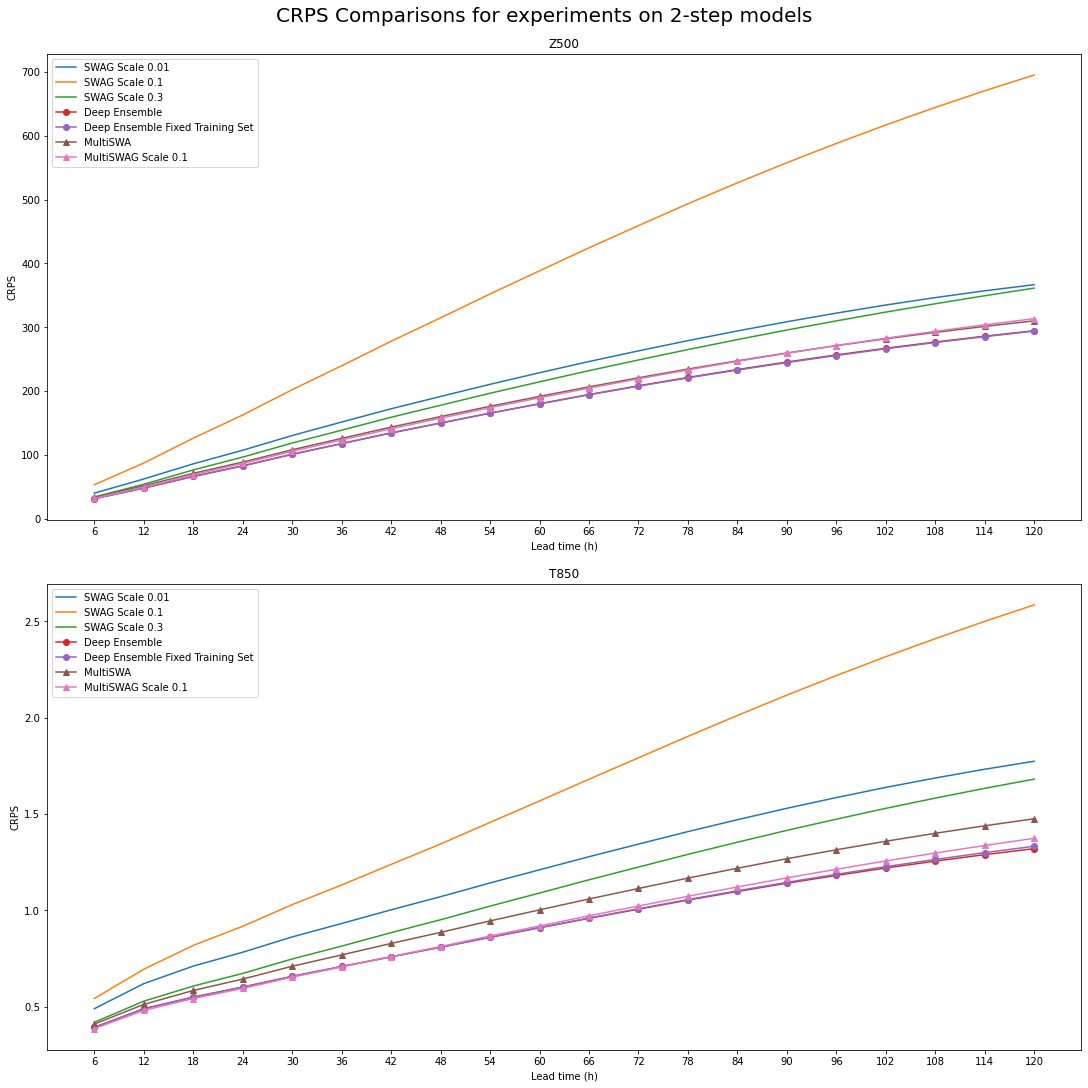

In [7]:
config_file = 'config_s01_two_steps_small.json'
ep = 11
lead_time = 6

# load config
with open("../configs/" + config_file) as json_data_file:
    cfg = json.load(json_data_file)

# define paths
datadir = cfg['directories']['datadir']
input_dir = datadir + cfg['directories']['input_dir']
model_save_path = datadir + cfg['directories']['model_save_path']
pred_save_path = datadir + cfg['directories']['pred_save_path']
metrics_path = datadir + cfg['directories']['metrics_path']

# model parameters
max_lead_time = cfg['training_constants']['max_lead_time']
len_sqce = cfg['model_parameters']['len_sqce']
delta_t = cfg['model_parameters']['delta_t']
architecture_name = cfg['model_parameters']['architecture_name']

description_epoch = "all_const_len{}_delta_{}_architecture_".format(len_sqce, delta_t) + architecture_name
descriptions = [
    description_epoch + f'_s02_swag_freq10_epoch_11_swag_scale001',
    description_epoch + f'_s02_swag_freq10_epoch_11_swag_scale01',
    description_epoch + f'_s02_swag_freq10_epoch_11_swag_scale03',
    description_epoch + '_s02_ensemble_epoch_11',
    description_epoch + f'_s02_fixed_data_ensemble_ensemble_epoch_11',
    description_epoch + f'_s02_multiswag_ensemble_epoch_11_swag_scale00',
    description_epoch + f'_s02_multiswag_ensemble_epoch_11_swag_scale01'
]

labels = [
    'SWAG Scale 0.01',
    'SWAG Scale 0.1',
    'SWAG Scale 0.3',
    'Deep Ensemble',
    'Deep Ensemble Fixed Training Set',
    'MultiSWA',
    'MultiSWAG Scale 0.1'
]

markers = ['', '', '', 'o', 'o', '^', '^']

file_paths = []

for description in descriptions:
    crps_filename = datadir + 'metrics/crps_' + description + '.nc'    
    file_paths.append(crps_filename)

crps_list = []
    
for path in file_paths:
    crps = xr.open_dataset(path)
    crps_list.append(crps)

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15), constrained_layout=True)
    
lead_times = np.arange(lead_time, max_lead_time + lead_time, lead_time)

for i, crps in enumerate(crps_list):
    ax1.plot(lead_times, crps.z.values, label=labels[i], marker=markers[i])
    
for i, crps in enumerate(crps_list):
    ax2.plot(lead_times, crps.t.values, label=labels[i], marker=markers[i])

ax1.set_xlabel('Lead time (h)')
ax1.set_xticks(lead_times)
ax2.set_xticks(lead_times)
ax2.set_xlabel('Lead time (h)')
ax1.set_ylabel('CRPS')
ax2.set_ylabel('CRPS')
ax1.set_title('Z500')
ax2.set_title('T850')

f.suptitle('CRPS Comparisons for experiments on 2-step models', fontsize=20)
ax1.legend()
ax2.legend()

filename = 'crps_comparisons.png'
plt.savefig(figures_path + filename)

plt.show()

In [8]:
df_crps = table(crps_list, labels)
df_crps

,Z500 6H,Z500 120H,T850 6H,T850 120H
Model,,,,
SWAG Scale 0.01,40.009,366.759,0.489,1.774
SWAG Scale 0.1,53.153,695.465,0.542,2.585
SWAG Scale 0.3,33.953,361.372,0.419,1.681
Deep Ensemble,31.251,294.512,0.393,1.320
Deep Ensemble Fixed Training Set,31.310,293.995,0.392,1.332
MultiSWA,33.477,310.111,0.409,1.475
MultiSWAG Scale 0.1,31.911,313.528,0.386,1.374


# CRPSS Comparisons

## Reference forecast : **Persistence**

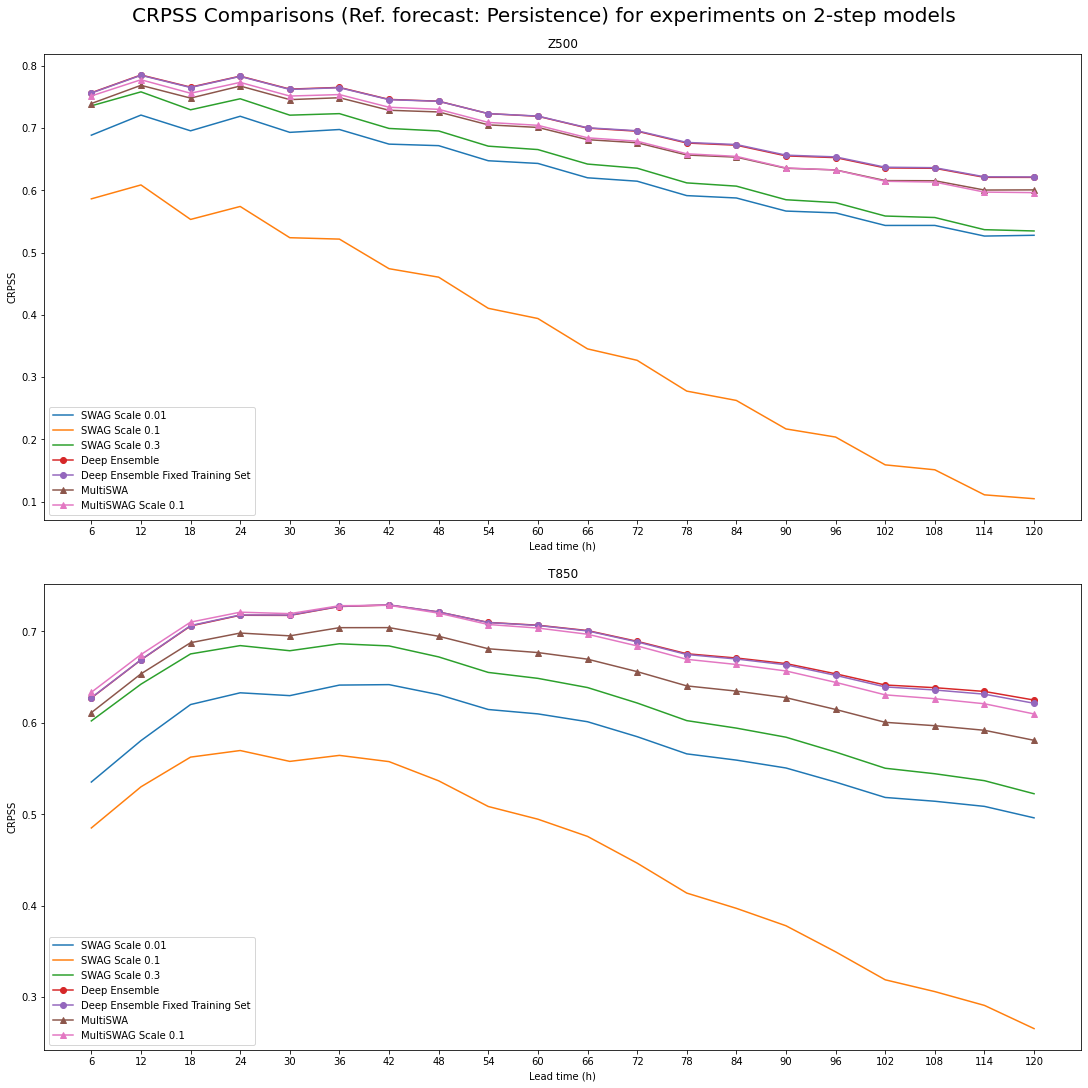

In [9]:
config_file = 'config_s01_two_steps_small.json'
ep = 11
lead_time = 6

# load config
with open("../configs/" + config_file) as json_data_file:
    cfg = json.load(json_data_file)

# define paths
datadir = cfg['directories']['datadir']
input_dir = datadir + cfg['directories']['input_dir']
model_save_path = datadir + cfg['directories']['model_save_path']
pred_save_path = datadir + cfg['directories']['pred_save_path']
metrics_path = datadir + cfg['directories']['metrics_path']

# model parameters
max_lead_time = cfg['training_constants']['max_lead_time']
len_sqce = cfg['model_parameters']['len_sqce']
delta_t = cfg['model_parameters']['delta_t']
architecture_name = cfg['model_parameters']['architecture_name']

description_epoch = "all_const_len{}_delta_{}_architecture_".format(len_sqce, delta_t) + architecture_name
descriptions = [
    description_epoch + f'_s02_swag_freq10_epoch_11_swag_scale001',
    description_epoch + f'_s02_swag_freq10_epoch_11_swag_scale01',
    description_epoch + f'_s02_swag_freq10_epoch_11_swag_scale03',
    description_epoch + '_s02_ensemble_epoch_11',
    description_epoch + f'_s02_fixed_data_ensemble_ensemble_epoch_11',
    description_epoch + f'_s02_multiswag_ensemble_epoch_11_swag_scale00',
    description_epoch + f'_s02_multiswag_ensemble_epoch_11_swag_scale01'
]

labels = [
    'SWAG Scale 0.01',
    'SWAG Scale 0.1',
    'SWAG Scale 0.3',
    'Deep Ensemble',
    'Deep Ensemble Fixed Training Set',
    'MultiSWA',
    'MultiSWAG Scale 0.1'
]

markers = ['', '', '', 'o', 'o', '^', '^']

file_paths = []

for description in descriptions:
    crps_filename = datadir + 'metrics/crps_' + description + '.nc'    
    file_paths.append(crps_filename)

crps_persistence = xr.open_dataset(datadir + 'metrics/crps_persistence.nc')
    
crpss_list = []
    
for path in file_paths:
    crps = xr.open_dataset(path)
    crpss = 1 - (crps/crps_persistence)
    crpss_list.append(crpss)
    


f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15), constrained_layout=True)
    
lead_times = np.arange(lead_time, max_lead_time + lead_time, lead_time)

for i, crpss in enumerate(crpss_list):
    ax1.plot(lead_times, crpss.z.values, label=labels[i], marker=markers[i])
    
for i, crpss in enumerate(crpss_list):
    ax2.plot(lead_times, crpss.t.values, label=labels[i], marker=markers[i])

ax1.set_xlabel('Lead time (h)')
ax1.set_xticks(lead_times)
ax2.set_xticks(lead_times)
ax2.set_xlabel('Lead time (h)')
ax1.set_ylabel('CRPSS')
ax2.set_ylabel('CRPSS')
ax1.set_title('Z500')
ax2.set_title('T850')

f.suptitle('CRPSS Comparisons (Ref. forecast: Persistence) for experiments on 2-step models', fontsize=20)
ax1.legend()
ax2.legend()

filename = 'crpss_persistence_comparisons.png'
plt.savefig(figures_path + filename)

plt.show()

In [10]:
df_crpss = table(crpss_list, labels)
df_crpss

,Z500 6H,Z500 120H,T850 6H,T850 120H
Model,,,,
SWAG Scale 0.01,0.689,0.528,0.535,0.496
SWAG Scale 0.1,0.586,0.105,0.485,0.265
SWAG Scale 0.3,0.736,0.535,0.602,0.522
Deep Ensemble,0.757,0.621,0.627,0.625
Deep Ensemble Fixed Training Set,0.756,0.621,0.627,0.621
MultiSWA,0.739,0.601,0.611,0.581
MultiSWAG Scale 0.1,0.752,0.596,0.633,0.610


## Reference forecast : **Weekly Climatology**

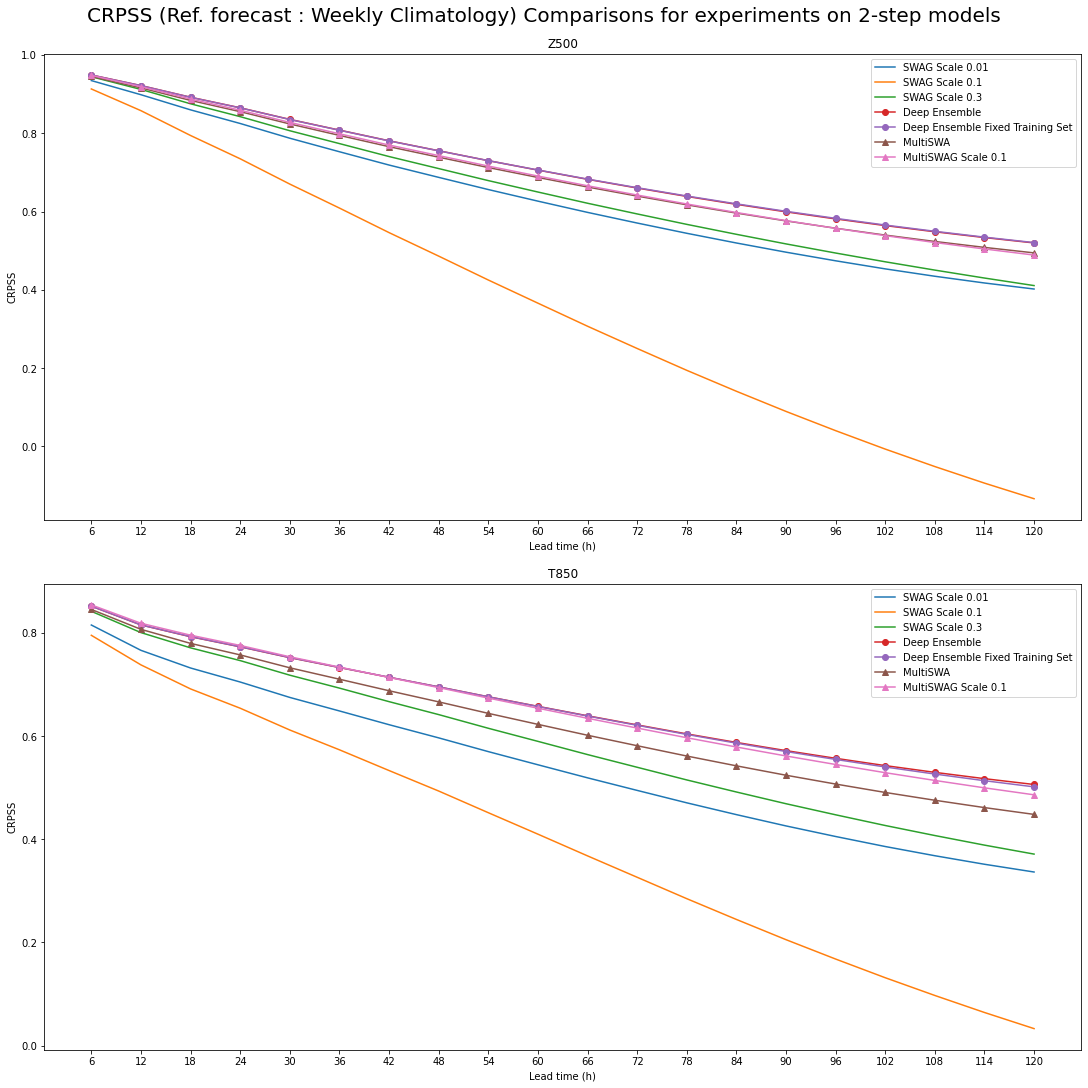

In [11]:
config_file = 'config_s01_two_steps_small.json'
ep = 11
lead_time = 6

# load config
with open("../configs/" + config_file) as json_data_file:
    cfg = json.load(json_data_file)

# define paths
datadir = cfg['directories']['datadir']
input_dir = datadir + cfg['directories']['input_dir']
model_save_path = datadir + cfg['directories']['model_save_path']
pred_save_path = datadir + cfg['directories']['pred_save_path']
metrics_path = datadir + cfg['directories']['metrics_path']

# model parameters
max_lead_time = cfg['training_constants']['max_lead_time']
len_sqce = cfg['model_parameters']['len_sqce']
delta_t = cfg['model_parameters']['delta_t']
architecture_name = cfg['model_parameters']['architecture_name']

description_epoch = "all_const_len{}_delta_{}_architecture_".format(len_sqce, delta_t) + architecture_name
descriptions = [
    description_epoch + f'_s02_swag_freq10_epoch_11_swag_scale001',
    description_epoch + f'_s02_swag_freq10_epoch_11_swag_scale01',
    description_epoch + f'_s02_swag_freq10_epoch_11_swag_scale03',
    description_epoch + '_s02_ensemble_epoch_11',
    description_epoch + f'_s02_fixed_data_ensemble_ensemble_epoch_11',
    description_epoch + f'_s02_multiswag_ensemble_epoch_11_swag_scale00',
    description_epoch + f'_s02_multiswag_ensemble_epoch_11_swag_scale01'
]

labels = [
    'SWAG Scale 0.01',
    'SWAG Scale 0.1',
    'SWAG Scale 0.3',
    'Deep Ensemble',
    'Deep Ensemble Fixed Training Set',
    'MultiSWA',
    'MultiSWAG Scale 0.1'
]

markers = ['', '', '', 'o', 'o', '^', '^']

file_paths = []

for description in descriptions:
    crps_filename = datadir + 'metrics/crps_' + description + '.nc'    
    file_paths.append(crps_filename)

crps_climatology = xr.open_dataset(datadir + 'metrics/crps_climatology.nc')
    
crpss_list = []
    
for path in file_paths:
    crps = xr.open_dataset(path)
    crpss = 1 - (crps/crps_climatology)
    crpss_list.append(crpss)
    


f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15), constrained_layout=True)
    
lead_times = np.arange(lead_time, max_lead_time + lead_time, lead_time)

for i, crpss in enumerate(crpss_list):
    ax1.plot(lead_times, crpss.z.values, label=labels[i], marker=markers[i])
    
for i, crpss in enumerate(crpss_list):
    ax2.plot(lead_times, crpss.t.values, label=labels[i], marker=markers[i])

ax1.set_xlabel('Lead time (h)')
ax1.set_xticks(lead_times)
ax2.set_xticks(lead_times)
ax2.set_xlabel('Lead time (h)')
ax1.set_ylabel('CRPSS')
ax2.set_ylabel('CRPSS')
ax1.set_title('Z500')
ax2.set_title('T850')

f.suptitle('CRPSS (Ref. forecast : Weekly Climatology) Comparisons for experiments on 2-step models', fontsize=20)
ax1.legend()
ax2.legend()

filename = 'crpss_climatology_comparisons.png'
plt.savefig(figures_path + filename)

plt.show()

In [12]:
df_crpss_clim = table(crpss_list, labels)
df_crpss_clim

,Z500 6H,Z500 120H,T850 6H,T850 120H
Model,,,,
SWAG Scale 0.01,0.935,0.402,0.815,0.337
SWAG Scale 0.1,0.913,-0.134,0.795,0.033
SWAG Scale 0.3,0.945,0.411,0.842,0.371
Deep Ensemble,0.949,0.520,0.852,0.506
Deep Ensemble Fixed Training Set,0.949,0.521,0.852,0.502
MultiSWA,0.945,0.494,0.845,0.448
MultiSWAG Scale 0.1,0.948,0.489,0.854,0.486
